# Iterative Modeling Process

To start our iterative modeling process, we will create a function to print out our metrics and create our qq plot. We will have to un-log-transform before calculating RMSE in order to have a comparable metric, so that will have to be included as an argument, as well as the model itself.

In [1]:
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
def get_model_data(model, is_log_transformed=False):
    
    train_r2, train_r2_adj = model.rsquared, model.rsquared_adj

    y_hat_train = model.predict(train.drop('price', axis=1))
    y_train = train['price']
    if is_log_transformed:
        train_rmse = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_hat_train)))
    else:
        train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
        
    y_hat_test = model.predict(test.drop('price', axis=1))
    y_test = test['price']
    if is_log_transformed:
        test_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_hat_test)))
    else:
        test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

    pvalues = model.pvalues.to_dict()
    significant_items = {}
    for key, value in pvalues.items():
        if value < 0.05:
            significant_items[key] = value
        
    print('R2 =', train_r2)
    print('R2 adjusted =', train_r2_adj)
    print('RMSE (train) =', train_rmse)
    print('RMSE (test) =', test_rmse)
    print('number of significant features =', len(significant_items))
    
    sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    plt.title('Q-Q Plot')

## Dropping Colinear Features

Here we drop the colinear features, as established in our exploratory data analysis.

In [4]:
train.drop(['yr_built', 'yr_renovated', 'yr_sold', 'yr_since_renovation'] , axis=1, inplace=True)
test.drop(['yr_built', 'yr_renovated', 'yr_sold', 'yr_since_renovation'] , axis=1, inplace=True)

R2 = 0.8189229383789512
R2 adjusted = 0.8178205932404954
RMSE (train) = 157985.98012359045
RMSE (test) = 140609.21109533816
number of significant features = 78


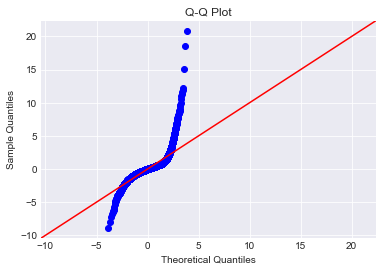

In [5]:
predictors = '+'.join(train.columns[1:])
formula = 'price' + '~' + predictors
model = ols(formula=formula, data=train).fit()
get_model_data(model)

## Removing Outliers

Our data has a lot of high outliers in the price variable, and one very high bedroom count that is likely a typo. We will fix the one error, then remove the outlighers higher than three times the standard deviation away from the mean. This will limit the range of house prices we can predict for, but will make for a much more accurate model. The mean and standard deviation our taken from our exploratory data analysis.

In [6]:
train[train['bedrooms']>15]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_basement,lat,long,yr_since_built,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
4196,640000.0,33,1.75,1620,6000,0.0,580.0,47.6878,-122.331,67,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train.at[4196, 'bedrooms'] = 3
train[train['bedrooms']>15]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_basement,lat,long,yr_since_built,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199


In [8]:
mean = 5.402966e+05
std = 3.673681e+05
lower_cutoff = mean - (3*std)
upper_cutoff = mean + (3*std)
lower_cutoff, upper_cutoff

(-561807.6999999998, 1642400.9)

Our lower cutoff is negative. Since we have no negative prices (our minimum from our exploratory data analysis was $78,000, and negative prices just don't make sense), we don't have to worry about our lower cutoff.

In [9]:
train = train[train['price'] < upper_cutoff]
test = test[test['price'] < upper_cutoff]

R2 = 0.8264414496035375
R2 adjusted = 0.8253755271400415
RMSE (train) = 107801.0153531246
RMSE (test) = 105098.35236656363
number of significant features = 82


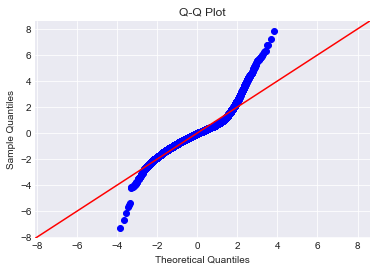

In [10]:
predictors = '+'.join(train.columns[1:])
formula = 'price' + '~' + predictors
model = ols(formula=formula, data=train).fit()
get_model_data(model)

The model looks a lot better after dropping values higher than three times the standard deviation. However, now we only have data within three times the standard deviation to work with. Our model will now only accurately predict house prices up to $1,642,400.

## Log Transforming Continuous Variables

We will log transform most of our continuous variables in order to make them more normally distributed. We won't transform longitude and latitude, as they can have negative values. yr_since_built and sqft_basement, as well, can be zero. Log transformations do not work on negative and zero values, so we will skip these columns.

The price column, our dependent variable, will be log transformed as well. This will get us better results, but it means we need to do the inverse transformation when calculating rmse values in order to get a comparable result.

In [11]:
train.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'waterfront', 'sqft_basement', 'lat', 'long', 'yr_since_built',
       'renovated', 'floors_15', 'floors_20', 'floors_25', 'floors_30',
       'floors_35', 'condition_2', 'condition_3', 'condition_4', 'condition_5',
       'grade_11', 'grade_12', 'grade_13', 'grade_3', 'grade_4', 'grade_5',
       'grade_6', 'grade_7', 'grade_8', 'grade_9', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056',

In [12]:
continuous = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']
for col in continuous:
    train[col] = train[col].map(np.log)
    test[col] = test[col].map(np.log)

R2 = 0.8566667276430895
R2 adjusted = 0.8557864359235365
RMSE (train) = 103013.87299746794
RMSE (test) = 99717.16956285348
number of significant features = 90


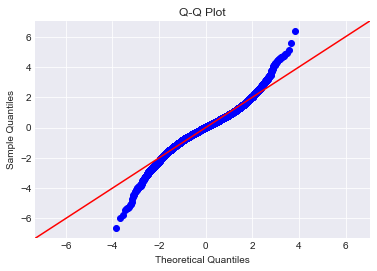

In [13]:
predictors = '+'.join(train.columns[1:])
formula = 'price' + '~' + predictors
model = ols(formula=formula, data=train).fit()
get_model_data(model, True)

## Removing Insignificant Features

Here we loop through our model multiple times. Each time we find the feature with the highest p-value and remove it if it is higher than 0.05. By doing this, we get rid of 9 insignificant features. By reviewing the model summary, we can verify that we are left with only significant ones.

In [14]:
model_dict = list(dict(model.pvalues).items())
model_dict.sort(key = lambda x: x[1], reverse=True)
highest_pvalue = model_dict[0]

while highest_pvalue[1] > 0.05:
    print(f'Dropping "{highest_pvalue[0]}" with p-value {highest_pvalue[1]}')
    train.drop(highest_pvalue[0], inplace = True, axis = 1)
    test.drop(highest_pvalue[0], inplace = True, axis = 1)
    
    predictors = '+'.join(train.columns[1:])
    formula = 'price' + '~' + predictors
    model = ols(formula=formula, data=train).fit()

    model_dict = list(dict(model.pvalues).items())
    model_dict.sort(key = lambda x: x[1], reverse=True)
    highest_pvalue = model_dict[0]

Dropping "zipcode_98003" with p-value 0.9081859817590578
Dropping "zipcode_98188" with p-value 0.780713820714147
Dropping "floors_20" with p-value 0.6356104612914132
Dropping "grade_3" with p-value 0.5856472881210619
Dropping "zipcode_98002" with p-value 0.5406474710298468
Dropping "floors_35" with p-value 0.349191640439133
Dropping "floors_25" with p-value 0.32369742178652816
Dropping "zipcode_98148" with p-value 0.15467038496210414
Dropping "zipcode_98198" with p-value 0.21086855197031598


R2 = 0.8566083994927416
R2 adjusted = 0.8558099143415273
RMSE (train) = 103086.41637514034
RMSE (test) = 99701.98273002672
number of significant features = 90


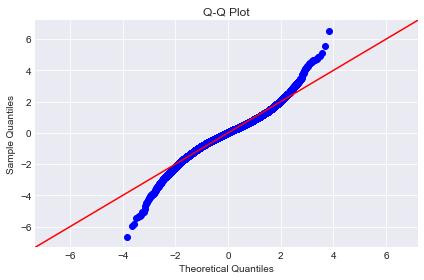

In [15]:
get_model_data(model, True)
plt.tight_layout()
plt.savefig('figures/final-qq-plot.png')
plt.show()

In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1073.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:24:14   Log-Likelihood:                 4484.5
No. Observations:               15892   AIC:                            -8791.
Df Residuals:                   15803   BIC:                            -8108.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -86.9633      7.303    -11.908      0.000    -101.278     -72.649
bedrooms          -0.0579      0.007     -8.035      0.000      -0.072      -0.044
bathrooms          0.0622      0.007      9.161      0.000       0.049       0.075
sqft_living        0.4838      0.008     58.381      0.000       0.468       0.500
sqft_lot           0.0666      0.002     27.881      0.000       0.062       0.071
waterfront         0.6028      0.025     24.519      0.000       0.555       0.651
sqft_basement  -5.321e-05   4.32e-06    -12.308      0.000   -6.17e-05   -4.47e-05
lat                0.6473      0.068      9.498      0.000       0.514       0.781
long              -0.5283      0.057     -9.223      0.000      -0.641      -0.416
yr_since_built     0.0004   9.36e-05      4.365      0.000       0.000       0.001
renovated          0.0622      0.009      7.124      0.000       0.045       0.079
floors_15          0.0153      0.006      2.652      0.008       0.004       0.027
floors_30         -0.0636      0.010     -6.196      0.000      -0.084      -0.043
condition_2        0.1893      0.046      4.091      0.000       0.099       0.280
condition_3        0.3135      0.044      7.197      0.000       0.228       0.399
condition_4        0.3483      0.044      7.997      0.000       0.263       0.434
condition_5        0.3987      0.044      9.107      0.000       0.313       0.484
grade_11           0.1344      0.014      9.598      0.000       0.107       0.162
grade_12           0.1776      0.038      4.646      0.000       0.103       0.252
grade_13        -1.13e-14   7.53e-16    -15.019      0.000   -1.28e-14   -9.83e-15
grade_4           -0.4159      0.042     -9.833      0.000      -0.499      -0.333
grade_5           -0.4607      0.018    -24.970      0.000      -0.497      -0.425
grade_6           -0.4109      0.011    -36.412      0.000      -0.433      -0.389
grade_7           -0.3326      0.009    -37.187      0.000      -0.350      -0.315
grade_8           -0.2208      0.008    -27.334      0.000      -0.237      -0.205
grade_9           -0.0821      0.008    -10.104      0.000      -0.098      -0.066
zipcode_98004      0.9512      0.025     38.601      0.000       0.903       0.999
zipcode_98005      0.5854      0.027     21.895      0.000       0.533       0.638
zipcode_98006      0.5714      0.021     27.371      0.000       0.530       0.612
zipcode_98007      0.5176      0.028     18.707      0.000       0.463       0.572
zipcode_98008      0.5419      0.026     20.881      0.000       0.491       0.593
zipcode_98010      0.3595      0.027     13.264      0.000       0.306       0.413
zipcode_98011      0.1953      0.033      5.922      0.000       0.131       0.260
zipcode_98014      0.2423      0.040      5.985      0.000       0.163       0.322
zipcode_9801

## Adding Interaction Features

We use the combinations function to create every possible combination of our continuous variables. Looping over them, we create a new interaction variable in our training set, dropping the two originals. We then make a new model with this train set, and check its R2 and adjusted R2.

In [17]:
from itertools import combinations

In [18]:
interactions = pd.DataFrame(columns = ['interaction', 'r2', 'r2_adj'])
interactions = interactions.append({'interaction':'baseline', 'r2':0.8566083994927416, 'r2_adj':0.8558099143415273}, ignore_index=True)
continuous = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_basement', 'lat', 'long', 'yr_since_built']
feat_combinations = combinations(continuous, 2)
for i, (a, b) in enumerate(feat_combinations):
    train_interactions = train.copy()
    train_interactions['interaction'] = train_interactions[a] * train_interactions[b]
    train_interactions.drop([a, b], axis=1, inplace=True)
    
    predictors_interactions = '+'.join(train_interactions.columns[1:])
    formula_interactions = 'price' + '~' + predictors_interactions
    model_interactions = ols(formula=formula_interactions, data=train_interactions).fit()
    train_r2, train_r2_adj = model_interactions.rsquared, model_interactions.rsquared_adj
    
    interactions = interactions.append({'interaction':f'{a}*{b}', 'r2':train_r2, 'r2_adj':train_r2_adj}, ignore_index=True)

In [19]:
interactions.sort_values(by=['r2'], ascending=False).head()

,interaction,r2,r2_adj
0,baseline,0.856608,0.855810
26,lat*long,0.856450,0.855660
4,bedrooms*sqft_basement,0.856086,0.855293
7,bedrooms*yr_since_built,0.856004,0.855212
16,sqft_living*lat,0.855948,0.855155


In [20]:
interactions.sort_values(by=['r2_adj'], ascending=False).head()

,interaction,r2,r2_adj
0,baseline,0.856608,0.855810
26,lat*long,0.856450,0.855660
4,bedrooms*sqft_basement,0.856086,0.855293
7,bedrooms*yr_since_built,0.856004,0.855212
16,sqft_living*lat,0.855948,0.855155


It looks like every interaction decreases both our R2 and adjusted R2. So, we will not include any interaction variables in our model.

## Cross Validation

We cross validate our data in order to verify that we aren't overfitting to our test set, and that there aren't outliers in our test set skewing the results. statsmodel does not have its own cross validation function, so we split the total data into parts manually, and loop over the resulting folds and calculate the rmse of each fold individually. The resulting values are near enough to each other that we can call this test a success.

In [21]:
def kfolds(data, k):
    # Force data as pandas DataFrame
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(k):
        if fold_n < leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold = data.iloc[start_obs : start_obs+fold_size+1] 
            start_obs += 1
        else:
            fold = data.iloc[start_obs : start_obs+fold_size] 
        start_obs += fold_size
        folds.append(fold)
            
    return folds

In [22]:
test_errs = []
k=5
folds = kfolds(pd.concat([train, test]).sample(frac=1, random_state=100), k)
for n in range(k):
    # Split in train and test for the fold
    fold_train = pd.concat([fold for i, fold in enumerate(folds) if i!=n])
    fold_test = folds[n]
    # Fit a linear regression model
    predictors = '+'.join(fold_train.columns[1:])
    formula = 'price' + '~' + predictors
    fold_model = ols(formula=formula, data=fold_train).fit()
    #Evaluate Test Errors
    y_hat_fold_test = fold_model.predict(fold_test.drop('price', axis=1))
    y_fold_test = fold_test['price']
    test_errs.append(np.sqrt(mean_squared_error(np.exp(y_fold_test), np.exp(y_hat_fold_test))))
print(test_errs)

[102263.4216279941, 103702.93643726473, 105491.1945506598, 100820.10288828705, 102073.61737834036]


Our cross validation scores are not far off from each other, so we do not have a problem.

## Residual Plots

Our residuals plot tells us where our errors lie. The distribution seems mostly evenly distributed around the horizontal axis, and not skewed left or right, so we have no problems here. We can save the parameters of our model to a csv to analyze later.

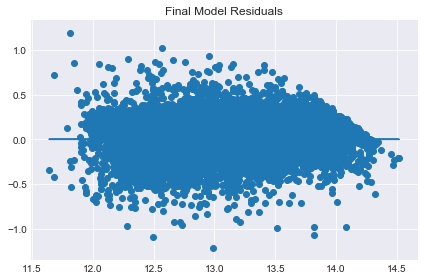

In [23]:
plt.scatter(model.predict(train.drop('price', axis = 1)), model.resid)
plt.plot(model.predict(train.drop('price', axis = 1)), [0 for i in range(len(train))])
plt.title('Final Model Residuals')
plt.tight_layout()
plt.savefig('figures/final-residuals-plot.png')
plt.show()

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1073.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:24:34   Log-Likelihood:                 4484.5
No. Observations:               15892   AIC:                            -8791.
Df Residuals:                   15803   BIC:                            -8108.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -86.9633      7.303    -11.908      0.000    -101.278     -72.649
bedrooms          -0.0579      0.007     -8.035      0.000      -0.072      -0.044
bathrooms          0.0622      0.007      9.161      0.000       0.049       0.075
sqft_living        0.4838      0.008     58.381      0.000       0.468       0.500
sqft_lot           0.0666      0.002     27.881      0.000       0.062       0.071
waterfront         0.6028      0.025     24.519      0.000       0.555       0.651
sqft_basement  -5.321e-05   4.32e-06    -12.308      0.000   -6.17e-05   -4.47e-05
lat                0.6473      0.068      9.498      0.000       0.514       0.781
long              -0.5283      0.057     -9.223      0.000      -0.641      -0.416
yr_since_built     0.0004   9.36e-05      4.365      0.000       0.000       0.001
renovated          0.0622      0.009      7.124      0.000       0.045       0.079
floors_15          0.0153      0.006      2.652      0.008       0.004       0.027
floors_30         -0.0636      0.010     -6.196      0.000      -0.084      -0.043
condition_2        0.1893      0.046      4.091      0.000       0.099       0.280
condition_3        0.3135      0.044      7.197      0.000       0.228       0.399
condition_4        0.3483      0.044      7.997      0.000       0.263       0.434
condition_5        0.3987      0.044      9.107      0.000       0.313       0.484
grade_11           0.1344      0.014      9.598      0.000       0.107       0.162
grade_12           0.1776      0.038      4.646      0.000       0.103       0.252
grade_13        -1.13e-14   7.53e-16    -15.019      0.000   -1.28e-14   -9.83e-15
grade_4           -0.4159      0.042     -9.833      0.000      -0.499      -0.333
grade_5           -0.4607      0.018    -24.970      0.000      -0.497      -0.425
grade_6           -0.4109      0.011    -36.412      0.000      -0.433      -0.389
grade_7           -0.3326      0.009    -37.187      0.000      -0.350      -0.315
grade_8           -0.2208      0.008    -27.334      0.000      -0.237      -0.205
grade_9           -0.0821      0.008    -10.104      0.000      -0.098      -0.066
zipcode_98004      0.9512      0.025     38.601      0.000       0.903       0.999
zipcode_98005      0.5854      0.027     21.895      0.000       0.533       0.638
zipcode_98006      0.5714      0.021     27.371      0.000       0.530       0.612
zipcode_98007      0.5176      0.028     18.707      0.000       0.463       0.572
zipcode_98008      0.5419      0.026     20.881      0.000       0.491       0.593
zipcode_98010      0.3595      0.027     13.264      0.000       0.306       0.413
zipcode_98011      0.1953      0.033      5.922      0.000       0.131       0.260
zipcode_98014      0.2423      0.040      5.985      0.000       0.163       0.322
zipcode_9801

In [25]:
model.params.to_csv('data/final_model.csv', header=False)